# Import Libraries

In [4]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR


! pip install torchsummary
from torchsummary import summary

%matplotlib inline

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [5]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [6]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [7]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# The model
Let's start with the model we first saw

In [8]:
dropout_value = 0.04


def norm_layer(norm_type, dimensions):
    if norm_type == "BN":
      # BN with output channel
      return(nn.BatchNorm2d(dimensions[0])) 
    elif norm_type == "LN":
      # LN with output channel and image size for the layer
      return(nn.LayerNorm(dimensions))
    elif norm_type == "GN":
      # GN with dividing output channel for each layer by 2 to form a group of 2
      return nn.GroupNorm(dimensions[0]//2, dimensions[0])
    else:
      raise ValueError('Options are BN / LN / GN')


class Net(nn.Module):
    def __init__(self, norm="BN"):
        super(Net, self).__init__()
        self.norm = norm

        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            norm_layer(self.norm, [10, 26, 26]), 
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            norm_layer(self.norm, [20, 24, 24]),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            norm_layer(self.norm, [16, 10, 10]),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            norm_layer(self.norm, [16, 8, 8]),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            norm_layer(self.norm, [20, 6, 6]),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels= 20, out_channels= 22, kernel_size=(1, 1), padding=0, bias=False),
            nn.Conv2d(in_channels=22, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
        ) 


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)        
        x = self.convblock7(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
           Dropout-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

lambda_1 = 0.01


# L1 Norm
def train(model, device, train_loader, optimizer, epoch, L1=False):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    # if using L1 regularization
    l1 = 1 if L1 else 0

    if l1:
      for p in model.parameters():
        l1 += torch.norm(p)

    loss += lambda_1 * l1
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))


In [11]:
norm_options = ["BN", "GN", "LN"]

metrics = {}

for norm in norm_options:
  model = Net(norm).to(device)
  print(f"Norm Type - { norm }")

  # print summary for norm type
  summary(model, input_size=(1, 28, 28))

  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []

  lambda_1 = 0.01

  EPOCHS = 20

  model =  Net(norm).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  scheduler = StepLR(optimizer, step_size=8, gamma=0.1)

  
  for epoch in range(EPOCHS):
      print("EPOCH:", epoch)

      # use L1 if norm is BN
      L1 = 1 if norm == "BN" else 0

      train(model, device, train_loader, optimizer, epoch, L1=L1)
      scheduler.step()
      test(model, device, test_loader)
  

  metrics[norm] = [train_losses, test_losses, train_acc, test_acc]

Norm Type - BN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
       BatchNorm2d-7           [-1, 20, 24, 24]              40
           Dropout-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14    

  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.5064590573310852 Batch_id=468 Accuracy=84.66: 100%|██████████| 469/469 [00:26<00:00, 17.95it/s]



Test set: Average loss: 0.0845, Accuracy: 9770/10000 (97.70%)

EPOCH: 1


Loss=0.4587540626525879 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:26<00:00, 17.84it/s]



Test set: Average loss: 0.0568, Accuracy: 9843/10000 (98.43%)

EPOCH: 2


Loss=0.44692492485046387 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:26<00:00, 17.58it/s]



Test set: Average loss: 0.0528, Accuracy: 9849/10000 (98.49%)

EPOCH: 3


Loss=0.38789036870002747 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:26<00:00, 17.43it/s]



Test set: Average loss: 0.0670, Accuracy: 9801/10000 (98.01%)

EPOCH: 4


Loss=0.4260020852088928 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:26<00:00, 17.45it/s]



Test set: Average loss: 0.0572, Accuracy: 9834/10000 (98.34%)

EPOCH: 5


Loss=0.32035842537879944 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:26<00:00, 17.45it/s]



Test set: Average loss: 0.0465, Accuracy: 9880/10000 (98.80%)

EPOCH: 6


Loss=0.33396023511886597 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:27<00:00, 17.29it/s]



Test set: Average loss: 0.0426, Accuracy: 9888/10000 (98.88%)

EPOCH: 7


Loss=0.3465449810028076 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:26<00:00, 17.48it/s]



Test set: Average loss: 0.0725, Accuracy: 9783/10000 (97.83%)

EPOCH: 8


Loss=0.2807164788246155 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:26<00:00, 17.41it/s]



Test set: Average loss: 0.0260, Accuracy: 9922/10000 (99.22%)

EPOCH: 9


Loss=0.2604006230831146 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:27<00:00, 17.37it/s]



Test set: Average loss: 0.0257, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.3118608593940735 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:26<00:00, 17.63it/s]



Test set: Average loss: 0.0254, Accuracy: 9928/10000 (99.28%)

EPOCH: 11


Loss=0.3042910695075989 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:27<00:00, 17.30it/s]



Test set: Average loss: 0.0245, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.2913430631160736 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:26<00:00, 17.48it/s]



Test set: Average loss: 0.0275, Accuracy: 9921/10000 (99.21%)

EPOCH: 13


Loss=0.2539977729320526 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:26<00:00, 17.53it/s]



Test set: Average loss: 0.0307, Accuracy: 9916/10000 (99.16%)

EPOCH: 14


Loss=0.2741937041282654 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:26<00:00, 17.51it/s]



Test set: Average loss: 0.0263, Accuracy: 9928/10000 (99.28%)

EPOCH: 15


Loss=0.269241064786911 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:27<00:00, 17.37it/s]



Test set: Average loss: 0.0250, Accuracy: 9938/10000 (99.38%)

EPOCH: 16


Loss=0.24507002532482147 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:27<00:00, 17.37it/s]



Test set: Average loss: 0.0231, Accuracy: 9941/10000 (99.41%)

EPOCH: 17


Loss=0.23963119089603424 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:26<00:00, 17.43it/s]



Test set: Average loss: 0.0221, Accuracy: 9945/10000 (99.45%)

EPOCH: 18


Loss=0.25123104453086853 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:26<00:00, 17.55it/s]



Test set: Average loss: 0.0230, Accuracy: 9943/10000 (99.43%)

EPOCH: 19


Loss=0.26505446434020996 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:27<00:00, 17.29it/s]



Test set: Average loss: 0.0215, Accuracy: 9944/10000 (99.44%)

Norm Type - GN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
         GroupNorm-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
         GroupNorm-7           [-1, 20, 24, 24]              40
           Dropout-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
        GroupNorm-13    

Loss=0.1487337350845337 Batch_id=468 Accuracy=78.52: 100%|██████████| 469/469 [00:24<00:00, 18.86it/s]



Test set: Average loss: 0.0908, Accuracy: 9747/10000 (97.47%)

EPOCH: 1


Loss=0.052094507962465286 Batch_id=468 Accuracy=96.87: 100%|██████████| 469/469 [00:24<00:00, 18.88it/s]



Test set: Average loss: 0.0604, Accuracy: 9820/10000 (98.20%)

EPOCH: 2


Loss=0.014957456849515438 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:25<00:00, 18.69it/s]



Test set: Average loss: 0.0496, Accuracy: 9854/10000 (98.54%)

EPOCH: 3


Loss=0.029608450829982758 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:24<00:00, 18.76it/s]



Test set: Average loss: 0.0414, Accuracy: 9871/10000 (98.71%)

EPOCH: 4


Loss=0.024631718173623085 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:24<00:00, 18.77it/s]



Test set: Average loss: 0.0387, Accuracy: 9881/10000 (98.81%)

EPOCH: 5


Loss=0.06379947066307068 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:25<00:00, 18.67it/s]



Test set: Average loss: 0.0371, Accuracy: 9889/10000 (98.89%)

EPOCH: 6


Loss=0.03147287294268608 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:25<00:00, 18.71it/s]



Test set: Average loss: 0.0318, Accuracy: 9899/10000 (98.99%)

EPOCH: 7


Loss=0.05004696175456047 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:25<00:00, 18.65it/s]



Test set: Average loss: 0.0295, Accuracy: 9919/10000 (99.19%)

EPOCH: 8


Loss=0.06764761358499527 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:24<00:00, 18.80it/s]



Test set: Average loss: 0.0265, Accuracy: 9922/10000 (99.22%)

EPOCH: 9


Loss=0.019347550347447395 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:25<00:00, 18.69it/s]



Test set: Average loss: 0.0254, Accuracy: 9925/10000 (99.25%)

EPOCH: 10


Loss=0.0114095164462924 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:25<00:00, 18.68it/s]



Test set: Average loss: 0.0252, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.004939469043165445 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:25<00:00, 18.50it/s]



Test set: Average loss: 0.0254, Accuracy: 9922/10000 (99.22%)

EPOCH: 12


Loss=0.03900469094514847 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:25<00:00, 18.54it/s]



Test set: Average loss: 0.0262, Accuracy: 9920/10000 (99.20%)

EPOCH: 13


Loss=0.0450151264667511 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:25<00:00, 18.72it/s]



Test set: Average loss: 0.0255, Accuracy: 9927/10000 (99.27%)

EPOCH: 14


Loss=0.006752340588718653 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:25<00:00, 18.54it/s]



Test set: Average loss: 0.0243, Accuracy: 9927/10000 (99.27%)

EPOCH: 15


Loss=0.055618803948163986 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:24<00:00, 18.79it/s]



Test set: Average loss: 0.0244, Accuracy: 9924/10000 (99.24%)

EPOCH: 16


Loss=0.00599524425342679 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:24<00:00, 18.79it/s]



Test set: Average loss: 0.0239, Accuracy: 9926/10000 (99.26%)

EPOCH: 17


Loss=0.005587546154856682 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [00:25<00:00, 18.60it/s]



Test set: Average loss: 0.0240, Accuracy: 9929/10000 (99.29%)

EPOCH: 18


Loss=0.07107555866241455 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:25<00:00, 18.70it/s]



Test set: Average loss: 0.0242, Accuracy: 9929/10000 (99.29%)

EPOCH: 19


Loss=0.07857705652713776 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:25<00:00, 18.52it/s]



Test set: Average loss: 0.0241, Accuracy: 9929/10000 (99.29%)

Norm Type - LN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
         LayerNorm-3           [-1, 10, 26, 26]          13,520
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,800
              ReLU-6           [-1, 20, 24, 24]               0
         LayerNorm-7           [-1, 20, 24, 24]          23,040
           Dropout-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             200
        MaxPool2d-10           [-1, 10, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,440
             ReLU-12           [-1, 16, 10, 10]               0
        LayerNorm-13    

Loss=0.08265768736600876 Batch_id=468 Accuracy=81.81: 100%|██████████| 469/469 [00:25<00:00, 18.51it/s]



Test set: Average loss: 0.0995, Accuracy: 9748/10000 (97.48%)

EPOCH: 1


Loss=0.18011243641376495 Batch_id=468 Accuracy=97.16: 100%|██████████| 469/469 [00:25<00:00, 18.57it/s]



Test set: Average loss: 0.0610, Accuracy: 9815/10000 (98.15%)

EPOCH: 2


Loss=0.01061332132667303 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:25<00:00, 18.47it/s]



Test set: Average loss: 0.0654, Accuracy: 9817/10000 (98.17%)

EPOCH: 3


Loss=0.12396026402711868 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:25<00:00, 18.43it/s]



Test set: Average loss: 0.0369, Accuracy: 9888/10000 (98.88%)

EPOCH: 4


Loss=0.06779038161039352 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:25<00:00, 18.41it/s]



Test set: Average loss: 0.0328, Accuracy: 9899/10000 (98.99%)

EPOCH: 5


Loss=0.03963102027773857 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:25<00:00, 18.32it/s]



Test set: Average loss: 0.0293, Accuracy: 9914/10000 (99.14%)

EPOCH: 6


Loss=0.01583511009812355 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:25<00:00, 18.47it/s]



Test set: Average loss: 0.0285, Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.010880322195589542 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:25<00:00, 18.38it/s]



Test set: Average loss: 0.0309, Accuracy: 9903/10000 (99.03%)

EPOCH: 8


Loss=0.008738773874938488 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:25<00:00, 18.35it/s]



Test set: Average loss: 0.0221, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.003406776115298271 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:25<00:00, 18.50it/s]



Test set: Average loss: 0.0222, Accuracy: 9929/10000 (99.29%)

EPOCH: 10


Loss=0.037510424852371216 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:25<00:00, 18.35it/s]



Test set: Average loss: 0.0226, Accuracy: 9932/10000 (99.32%)

EPOCH: 11


Loss=0.00459494860842824 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:25<00:00, 18.30it/s]



Test set: Average loss: 0.0216, Accuracy: 9939/10000 (99.39%)

EPOCH: 12


Loss=0.004277570638805628 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:25<00:00, 18.48it/s]



Test set: Average loss: 0.0216, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.002894520526751876 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:25<00:00, 18.42it/s]



Test set: Average loss: 0.0218, Accuracy: 9934/10000 (99.34%)

EPOCH: 14


Loss=0.0066026560962200165 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:25<00:00, 18.45it/s]



Test set: Average loss: 0.0216, Accuracy: 9936/10000 (99.36%)

EPOCH: 15


Loss=0.004785602446645498 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:25<00:00, 18.33it/s]



Test set: Average loss: 0.0214, Accuracy: 9937/10000 (99.37%)

EPOCH: 16


Loss=0.03230401501059532 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:25<00:00, 18.32it/s]



Test set: Average loss: 0.0215, Accuracy: 9940/10000 (99.40%)

EPOCH: 17


Loss=0.0070692491717636585 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:25<00:00, 18.55it/s]



Test set: Average loss: 0.0214, Accuracy: 9940/10000 (99.40%)

EPOCH: 18


Loss=0.007739424239844084 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:25<00:00, 18.35it/s]



Test set: Average loss: 0.0215, Accuracy: 9939/10000 (99.39%)

EPOCH: 19


Loss=0.028296491131186485 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:25<00:00, 18.51it/s]



Test set: Average loss: 0.0214, Accuracy: 9939/10000 (99.39%)



Graphs for train and test accuracy 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


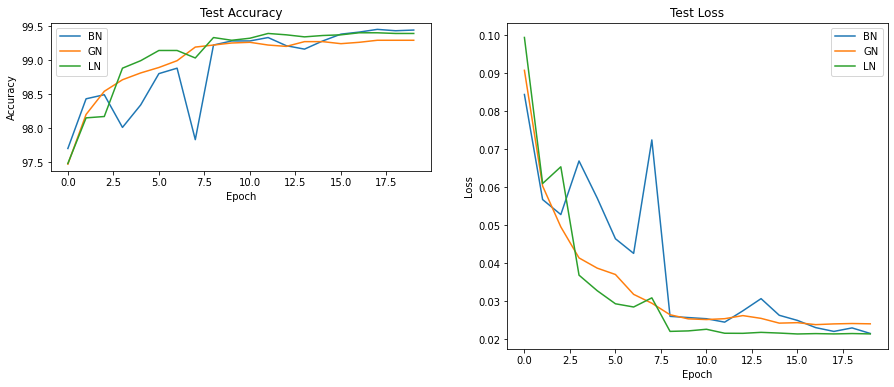

In [14]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 6]


for norm in norm_options:
  train_losses = metrics[norm][0]
  test_losses = metrics[norm][1]
  train_acc = metrics[norm][2]
  test_acc = metrics[norm][3]

  plt.subplot(2,2, 1)

  plt.plot(test_acc)
  plt.legend(norm_options)
  plt.title("Test Accuracy")

  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')

  plt.subplot(1,2,2)
  plt.plot(test_losses)
  plt.legend(norm_options)
  plt.title('Test Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

--------------- BN --------------- 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


--------------- GN --------------- --------------- LN --------------- 

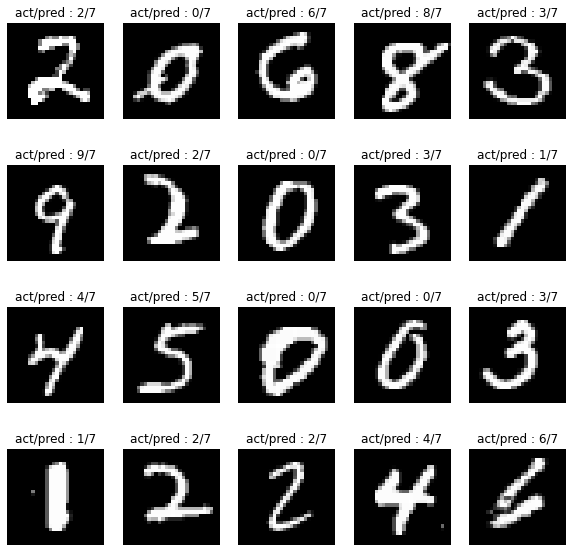

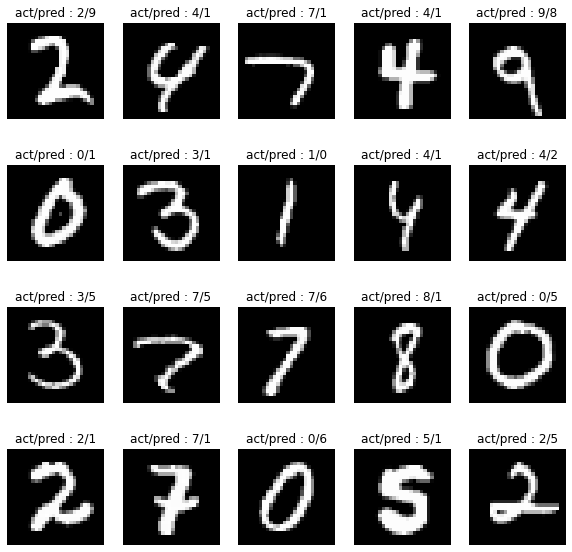

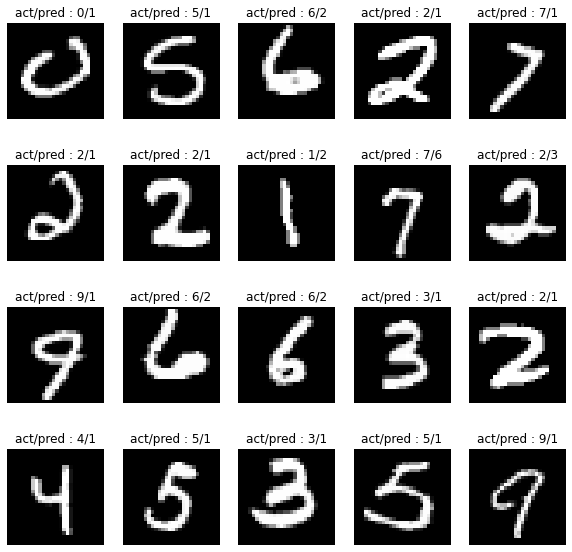

In [17]:
classes = ('0','1','2','3','4','5','6','7','8','9')

for norm in norm_options:

  print('-'*15,end=' ')
  print(norm,end=' ')
  print('-'*15,end = ' ')

  model = Net(norm).to(device)

  model.eval()

  figure = plt.figure(figsize=(10, 10))
  num_of_images = 20
  index = 1

  misclass_img_list = []
  untrans_img=[]

  with torch.no_grad():

      for data, target in test_loader:
          data, target = data.to(
              device), target.to(device)
          output = model(data)
          pred = output.argmax(dim=1, keepdim=True)
          act = target.view_as(pred)
          # since most of the bool vec is true (good problem to have) and switch (flip) the true to false and vice versa
          bool_vec = ~pred.eq(act)

          # now extract the index number from the tensor which has 'true'
          idx = list(
              np.where(bool_vec.cpu().numpy())[0])

          if idx:  # if not a blank list
              idx_list = idx
              # print(data[idx_list[0]].shape)
              if index < num_of_images+1:
                  plt.subplot(4, 5, index)
                  plt.axis('off')
                  titl = 'act/pred : ' + \
                      str(classes[target[idx[0]].cpu().item(
                      )]) + '/' + str(classes[pred[idx[0]].cpu().item()])
                  # prints the 1st index of each batch.
              
                  img = data[idx[0]].cpu()
                  untrans_img.append(img.squeeze_(0))
                  image = plt.imshow(img,  cmap='gray')
                  misclass_img_list.append(image)
                                    
                  plt.title(titl)
                  index += 1